In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv("model data cleaned.csv")

In [3]:
# Identify feature types
numeric_features = ['Ambiance_Label_Num', 'Rating_Value_Normalized', 'Avg_Price_Normalized', 'Price_Category_Num']

# Extract cuisine features (lowercase columns)
cuisine_features = [col for col in df.columns if col.islower() and col not in numeric_features]

# Extract suburb features
suburb_features = [col for col in df.columns if col.startswith("Suburb_")]

# Combine all selected features
selected_features = numeric_features + cuisine_features + suburb_features

# Select features from DataFrame
features = df[selected_features]

# Convert to numpy array
X = features.to_numpy()


In [4]:
# Initialize k-NN model (using cosine similarity)
knn = NearestNeighbors(n_neighbors=5, metric='cosine')

# Fit model
knn.fit(X)

NearestNeighbors(metric='cosine')

In [5]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

def leave_one_out_evaluation(df, features_array, knn_model):
    total_restaurants = len(df)
    total_score = 0

    # Identify cuisine-related columns
    cuisine_columns = [col for col in df.columns if col.islower() and col not in [
        'Ambiance_Label_Num', 'Rating_Value_Normalized', 'Avg_Price_Normalized', 'Price_Category_Num'
    ]]

    for i in range(total_restaurants):
        # Exclude the current restaurant from training
        train_features = np.delete(features_array, i, axis=0)
        test_features = features_array[i].reshape(1, -1)

        # Train a temporary KNN model
        temp_model = NearestNeighbors(n_neighbors=30, metric='cosine')
        temp_model.fit(train_features)

        # Extract cuisines for the test restaurant
        test_cuisines = set([col for col, val in df.iloc[i].items() if val == 1 and col in cuisine_columns])

        # Find the 10 nearest neighbors
        _, indices = temp_model.kneighbors(test_features, n_neighbors=30)

        recommended_indices = [idx if idx < i else idx + 1 for idx in indices[0]]
        best_score = 0
        for idx in recommended_indices:
            # Extract cuisines for recommended restaurant
            recommended_cuisines = set([col for col, val in df.iloc[idx].items() if val == 1 and col in cuisine_columns])

            # Calculate similarity scores
            cuisine_score = len(test_cuisines.intersection(recommended_cuisines)) / max(len(test_cuisines), 1)
            rating_score = 1 - abs(df.iloc[i]["Rating_Value_Normalized"] - df.iloc[idx]["Rating_Value_Normalized"]) / 5
            price_score = 1 - abs(df.iloc[i]["Avg_Price_Normalized"] - df.iloc[idx]["Avg_Price_Normalized"]) / max(df["Avg_Price_Normalized"])

            # Weighted scoring
            total_recommendation_score = (0.5 * cuisine_score) + (0.35 * rating_score) + (0.25 * price_score) 
            best_score = max(best_score, total_recommendation_score)
        
        total_score += best_score

    return total_score / total_restaurants

# Run the evaluation
hit_rate = leave_one_out_evaluation(df, X, knn)
print(f"Hit rate: {hit_rate:.4f}")


Hit rate: 0.9797


In [29]:
def recommend_restaurants(restaurant_name, df, knn_model, features_array, original_df, top_n=5):
    import unicodedata
    
    # Function to normalize text (remove accents and convert to lowercase) for a more user friendly approach
    def normalize_text(text):
        # Convert to lowercase and normalize unicode characters
        text = text.lower()
        # Remove accents
        text = ''.join(c for c in unicodedata.normalize('NFD', text)
                      if unicodedata.category(c) != 'Mn')
        return text
    
    # Normalizing the input restaurant name
    normalized_input = normalize_text(restaurant_name)
    
    # Finding the closest match in the dataset
    best_match = None
    for idx, name in enumerate(original_df['Restaurant Name']):
        normalized_name = normalize_text(name)
        if normalized_input == normalized_name:
            best_match = idx
            break

        
    # If no match found (error handling)
    if best_match is None:
        return "No recommendations found or restaurant name is incorrect."
    
    # Getting the restaurant features
    restaurant_features = features_array[best_match].reshape(1, -1)
    
    # Getting recommendations
    distances, indices = knn_model.kneighbors(restaurant_features, n_neighbors=top_n+1)
    
    recommended_restaurants = original_df.iloc[indices[0][1:]][['Restaurant Name', 'Rating_Value', 'Review_Count','Opening Hours','Avg_Price','Price_Category','Contact Number','Address','Suburb','Reservations',
                                                       'Ambiance','Ambiance_Label']].copy()
    
     # Identify cuisine-related columns
    cuisine_columns = [col for col in df.columns if col.islower() and col not in [
        'Ambiance_Label_Num', 'Rating_Value_Normalized', 'Avg_Price_Normalized', 'Price_Category_Num'
    ]]
    
    recommended_restaurants['Cuisine'] = original_df.iloc[indices[0][1:]][cuisine_columns].apply(
        lambda row: ', '.join([col for col, val in row.items() if val == 1]), axis=1
    )
    return recommended_restaurants
#Testing the model
recommend_restaurants("bodega ramen", df, knn, X, df)        

,Restaurant Name,Rating_Value,Review_Count,Opening Hours,Avg_Price,Price_Category,Contact Number,Address,Suburb,Reservations,Ambiance,Ambiance_Label,Cuisine
53,Minato Sushi,4.7,132.0,Monday - Sunday: 12:00-33:00,225.0,Medium Expensive,+27 21 418 4057,"71 Waterkant St, Cape Town City Centre, Cape T...",Cape Town City Centre,https://minatosushi.co.za/reservation/,"A quaint, family-friendly sushi spot with a wa...",Traditional & Inviting Atmosphere,asian
49,How'S Your Oni?,4.7,202.0,Wednesday 12:00-33:00; Thursday 12:00-33:00; F...,250.0,Medium Expensive,+27 83 899 1386,"47 Main Rd, Green Point, Cape Town, 8005",Green Point,https://www.dineplan.com/restaurants/hows-your...,"A trendy Korean spot with a cozy, minimalist v...",Modern & Cozy Dining,korean
70,Vixi Social House,4.5,1496.0,Tuesday 12:00-35:00; Wednesday 12:00-35:00; Th...,425.0,Medium Expensive,+27 21 418 1338,"49 Bree Street, Strand St, CBD, Cape Town, 8000",Cape Town City Centre,https://www.dineplan.com/restaurants/vixi-soci...,"An edgy, contemporary eatery on Bree Street wh...",Trendy & Vibrant Casual Dining,steakhouse
78,Sloppy Sam,4.5,149.0,Monday Closed; Tuesday 29:30-34:00; Wednesday ...,225.0,Medium Expensive,+27 82 377 3707,"Heritage Square, 100 Shortmarket St, CBD, Cape...",Cape Town City Centre,823773707,"Located in Cape Town's Heritage Square, Sloppy...",Trendy & Vibrant Casual Dining,meditterean
43,Aiko Sushi,4.5,1687.0,11:30-34:00,200.0,Medium Expensive,+27 21 418 0064,"4 Bree St, Cape Town City Centre, Cape Town, 8000",Cape Town City Centre,https://www.dineplan.com/restaurants/aiko-sushi,"A sleek and trendy sushi spot on Bree Street, ...",Trendy & Vibrant Casual Dining,asian


In [7]:
df.to_excel("model data cleaned.xlsx")
print("Excel file saved successfully!")

Excel file saved successfully!


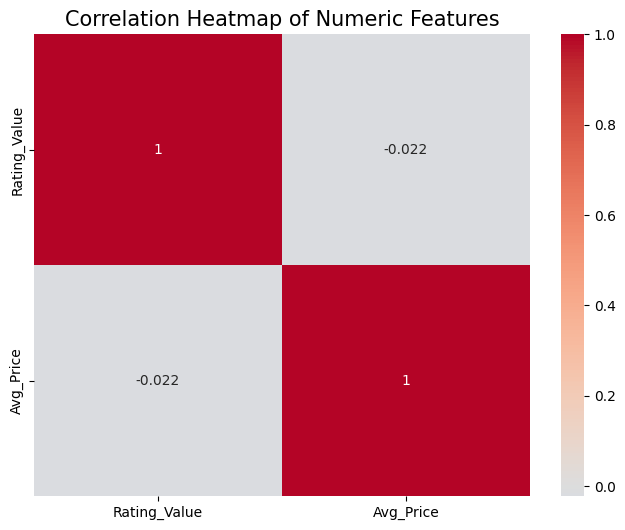

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
# 3. Heatmap of Numeric Features
numeric_features = df[['Rating_Value', 'Avg_Price']]
plt.figure(figsize=(8, 6))
sns.heatmap(numeric_features.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Numeric Features', fontsize=15)
plt.show()

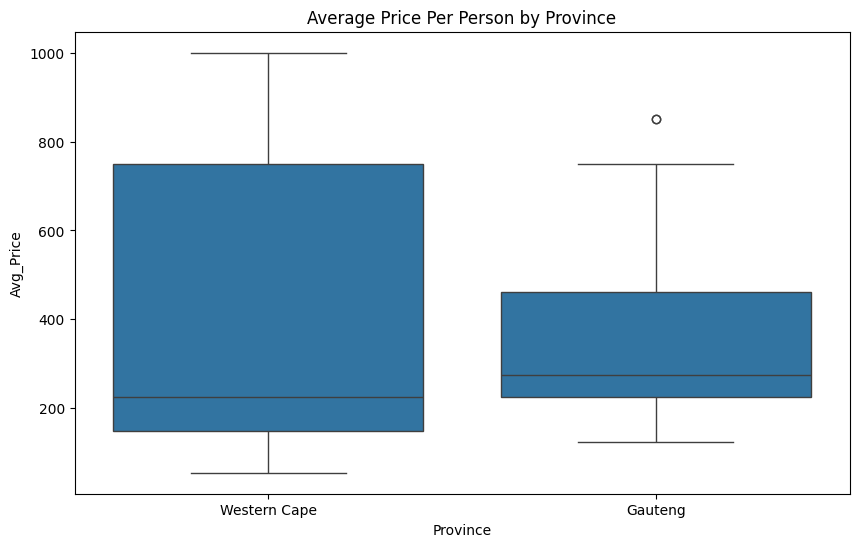

In [9]:
# Box plot of Avg_Price by Province
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Province', y='Avg_Price')
plt.title('Average Price Per Person by Province')
plt.xlabel('Province')
plt.ylabel('Avg_Price')
plt.show()


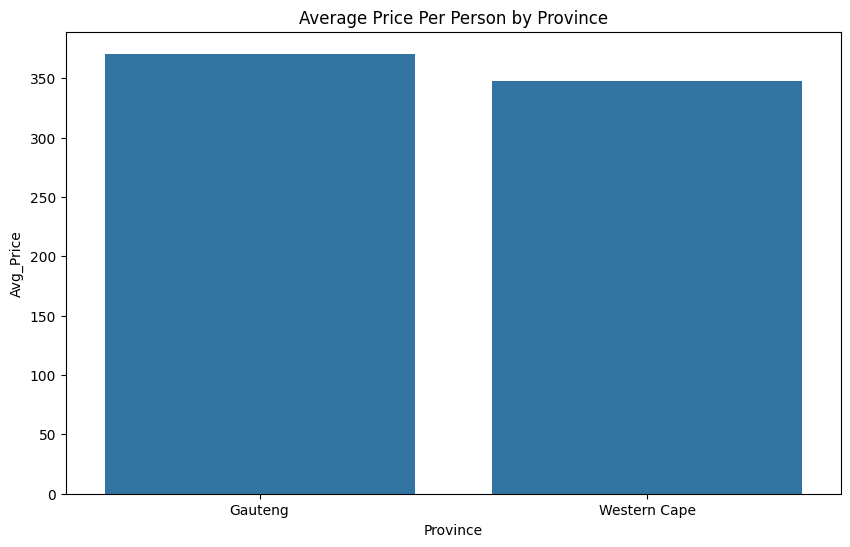

In [10]:
# Bar plot of mean Avg_Price by Province
mean_prices = df.groupby('Province')['Avg_Price'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=mean_prices, x='Province', y='Avg_Price')
plt.title('Average Price Per Person by Province')
plt.xlabel('Province')
plt.ylabel('Avg_Price')
plt.show()

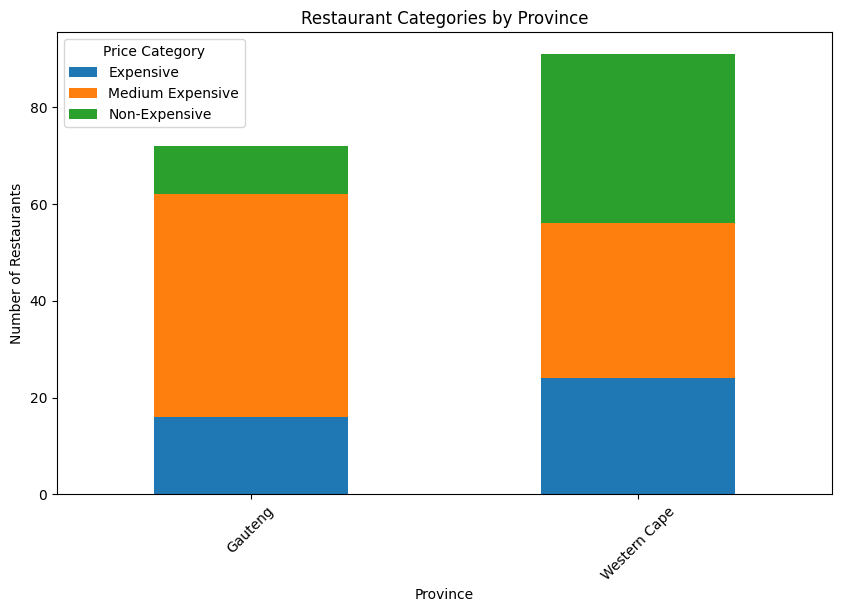

In [11]:
# Count restaurants in each price category by Province
category_counts = df.groupby(['Province', 'Price_Category']).size().unstack().fillna(0)

# Stacked bar plot
category_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Restaurant Categories by Province')
plt.xlabel('Province')
plt.ylabel('Number of Restaurants')
plt.xticks(rotation=45)
plt.legend(title='Price Category')
plt.show()


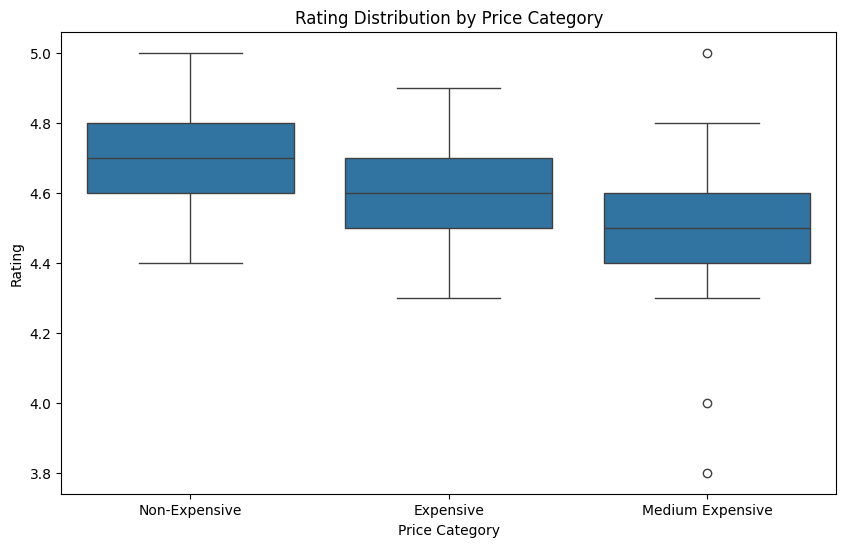

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Price_Category', y='Rating_Value')
plt.title('Rating Distribution by Price Category')
plt.xlabel('Price Category')
plt.ylabel('Rating')
plt.show()

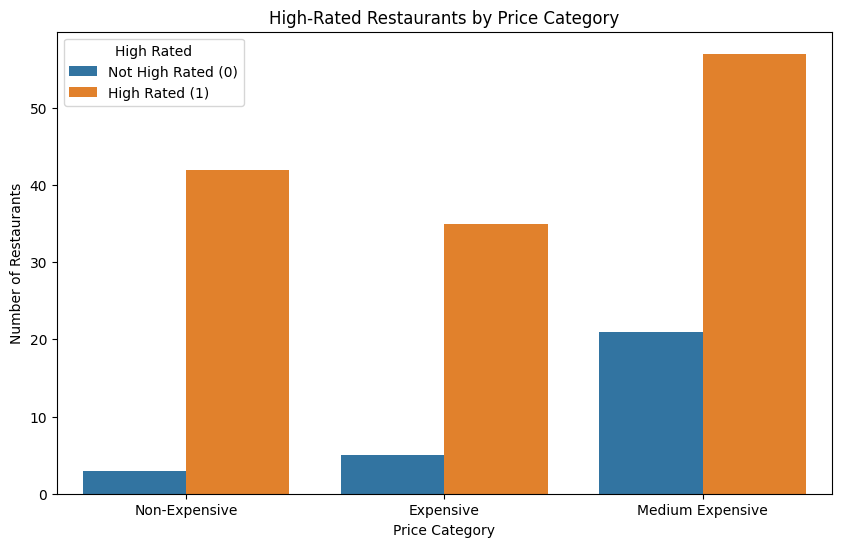

In [13]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Price_Category', hue='High_Rated')
plt.title('High-Rated Restaurants by Price Category')
plt.xlabel('Price Category')
plt.ylabel('Number of Restaurants')
plt.legend(title='High Rated', labels=['Not High Rated (0)', 'High Rated (1)'])
plt.show()

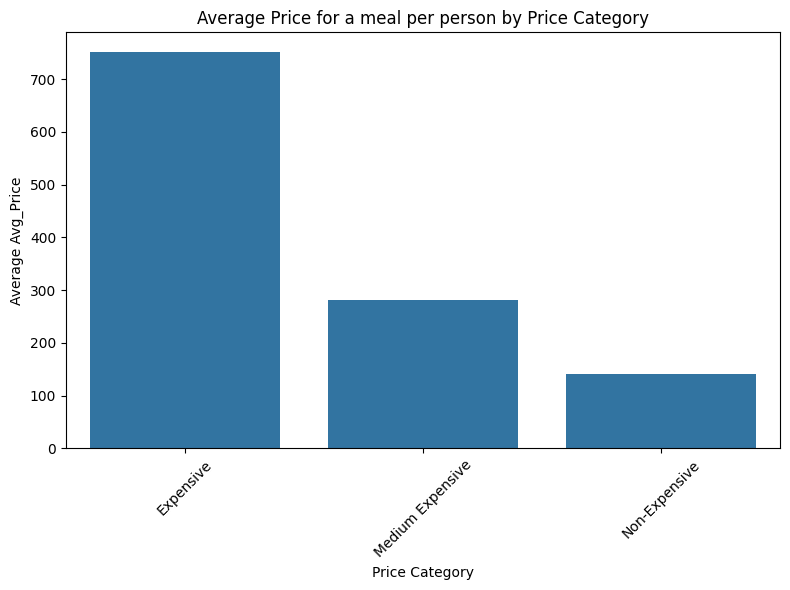

In [14]:
# Calculate the average Avg_Price for each Price_Category
avg_price_by_category = df.groupby('Price_Category')['Avg_Price'].mean().reset_index()

# Create a bar chart using seaborn
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
sns.barplot(x='Price_Category', y='Avg_Price', data=avg_price_by_category)

plt.xlabel('Price Category')
plt.ylabel('Average Avg_Price')
plt.title('Average Price for a meal per person by Price Category')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

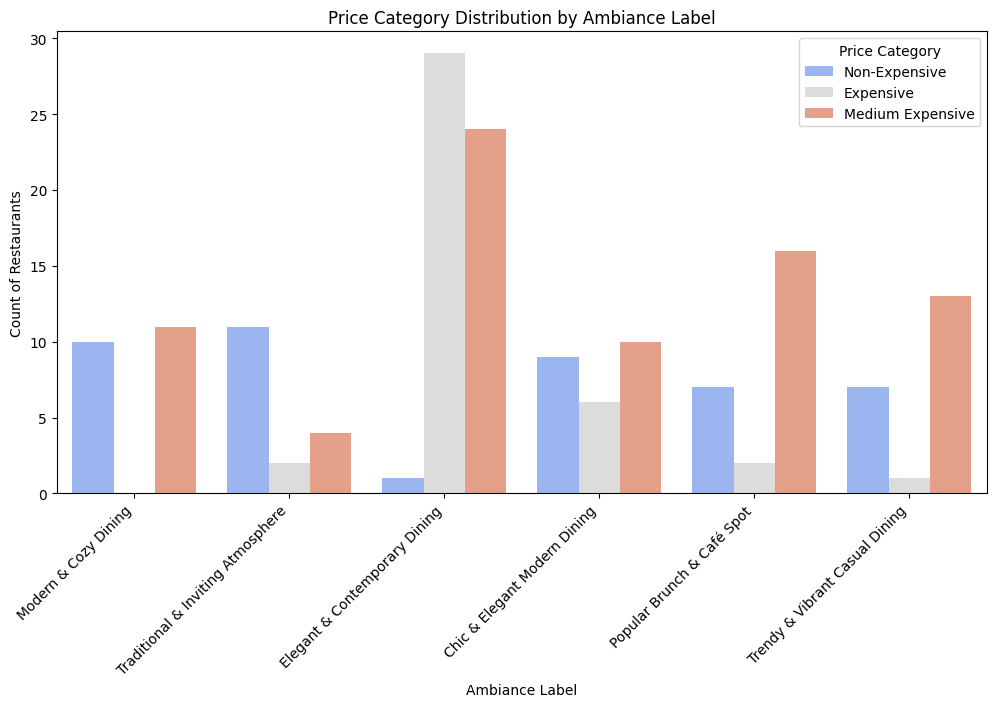

In [15]:
#Comparing the distribution of price categories across different ambiance categories/labels.
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Ambiance_Label', hue='Price_Category', palette='coolwarm')

plt.xticks(rotation=45, ha='right')
plt.xlabel("Ambiance Label")
plt.ylabel("Count of Restaurants")
plt.title("Price Category Distribution by Ambiance Label")
plt.legend(title="Price Category")
plt.show()

C:\Users\Game\AppData\Local\Temp\ipykernel_8792\3251328233.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Ambiance_Label', y='Rating_Value', palette='viridis')


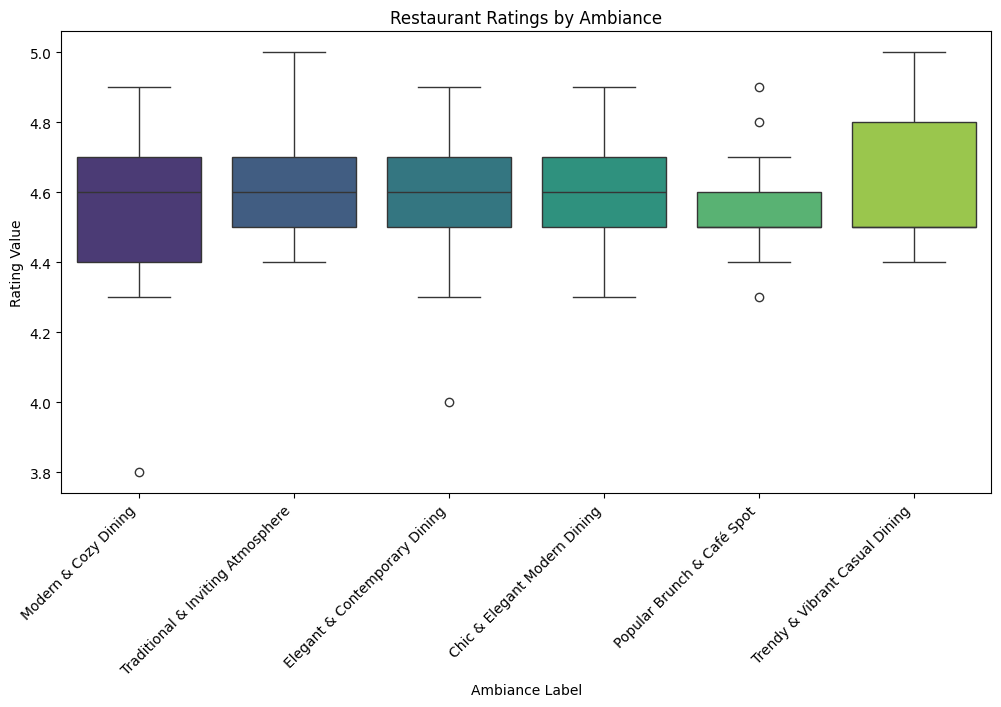

In [16]:
#Comparing the rating distribution across ambiance categories
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Ambiance_Label', y='Rating_Value', palette='viridis')

plt.xticks(rotation=45, ha='right')
plt.xlabel("Ambiance Label")
plt.ylabel("Rating Value")
plt.title("Restaurant Ratings by Ambiance")
plt.show()


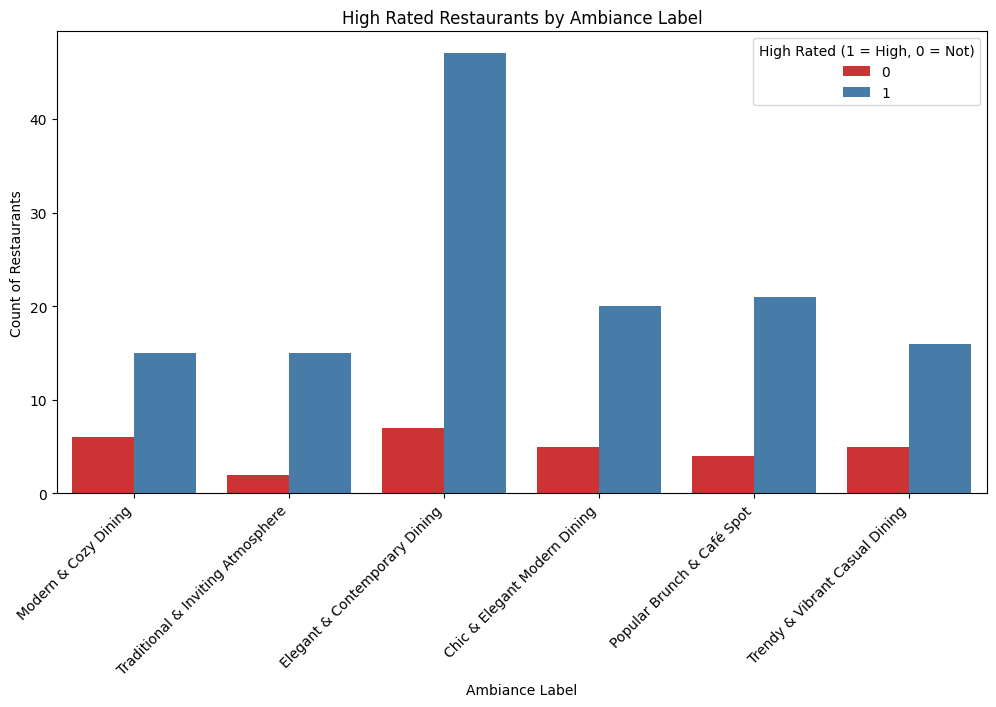

In [17]:
#proportion of high-rated restaurants in each ambiance category.
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Ambiance_Label', hue='High_Rated', palette='Set1')

plt.xticks(rotation=45, ha='right')
plt.xlabel("Ambiance Label")
plt.ylabel("Count of Restaurants")
plt.title("High Rated Restaurants by Ambiance Label")
plt.legend(title="High Rated (1 = High, 0 = Not)")
plt.show()

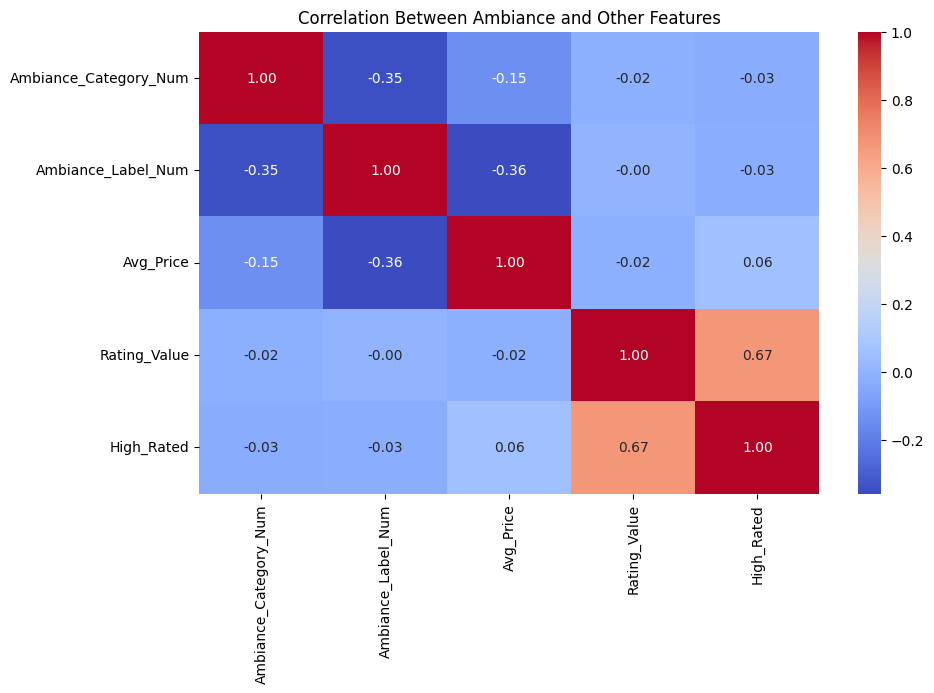

In [18]:
df['Ambiance_Category_Num'] = LabelEncoder().fit_transform(df['Ambiance_Category'])
df['Ambiance_Label_Num'] = LabelEncoder().fit_transform(df['Ambiance_Label'])

plt.figure(figsize=(10, 6))
sns.heatmap(df[['Ambiance_Category_Num', 'Ambiance_Label_Num', 'Avg_Price', 'Rating_Value', 'High_Rated']].corr(), 
            annot=True, cmap='coolwarm', fmt=".2f")

plt.title("Correlation Between Ambiance and Other Features")
plt.show()

C:\Users\Game\AppData\Local\Temp\ipykernel_8792\3317392584.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_reviews['Restaurant Name'], y=top_reviews['Review_Count'], palette="flare")


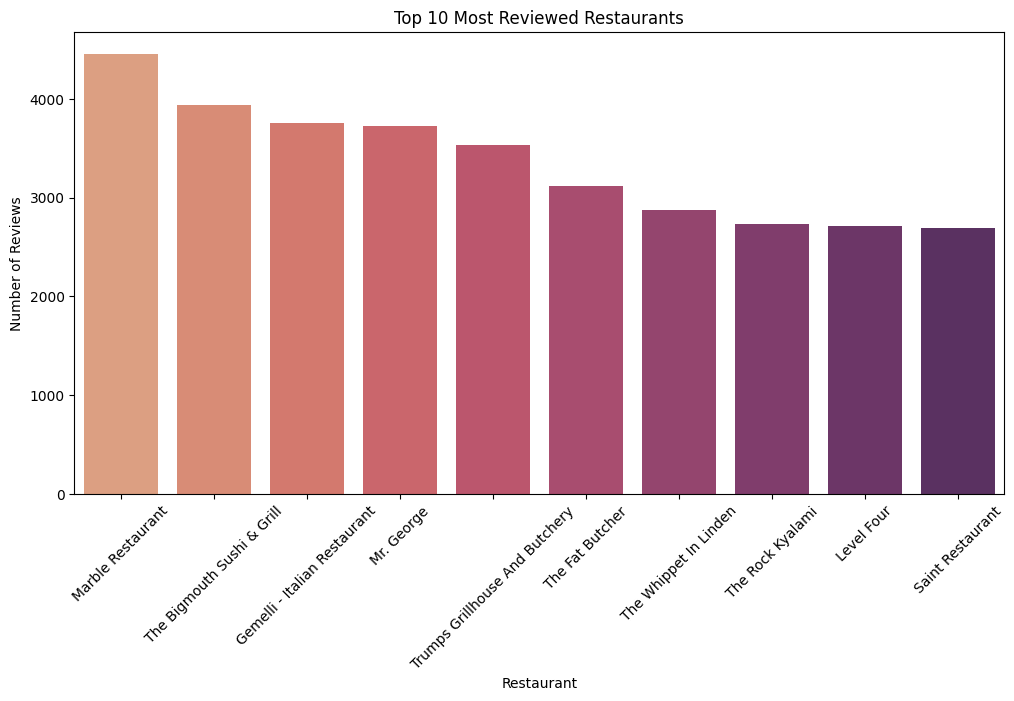

In [19]:
# Top 10 most reviewed restaurants
top_reviews = df[['Restaurant Name', 'Review_Count']].sort_values(by='Review_Count', ascending=False)[:10]
plt.figure(figsize=(12, 6))
sns.barplot(x=top_reviews['Restaurant Name'], y=top_reviews['Review_Count'], palette="flare")
plt.xticks(rotation=45)
plt.xlabel("Restaurant")
plt.ylabel("Number of Reviews")
plt.title("Top 10 Most Reviewed Restaurants")
plt.show()

C:\Users\Game\AppData\Local\Temp\ipykernel_8792\2073574317.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_reviews['Restaurant Name'], y=top_reviews['Rating_Value'], palette="flare")


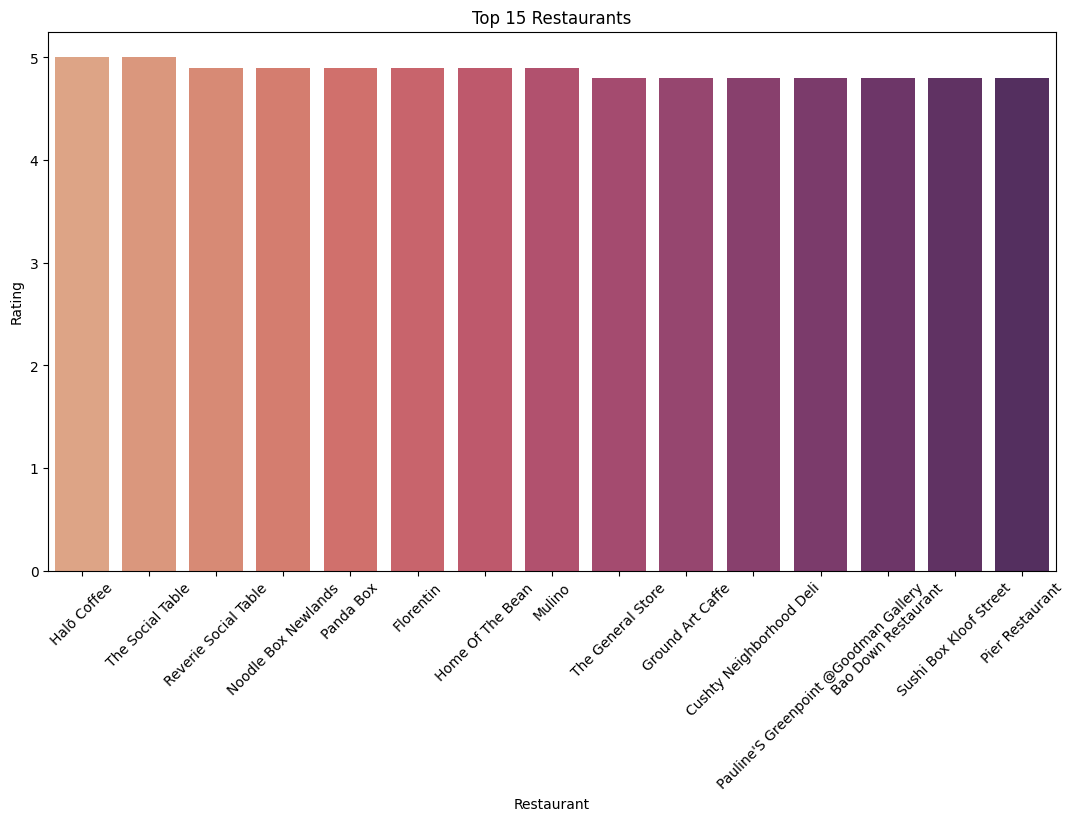

In [20]:
# Top 15 restaurants
top_reviews = df[['Restaurant Name', 'Rating_Value']].sort_values(by='Rating_Value', ascending=False)[:15]
plt.figure(figsize=(13, 7))
sns.barplot(x=top_reviews['Restaurant Name'], y=top_reviews['Rating_Value'], palette="flare")
plt.xticks(rotation=45)
plt.xlabel("Restaurant")
plt.ylabel("Rating")
plt.title("Top 15 Restaurants")
plt.show()

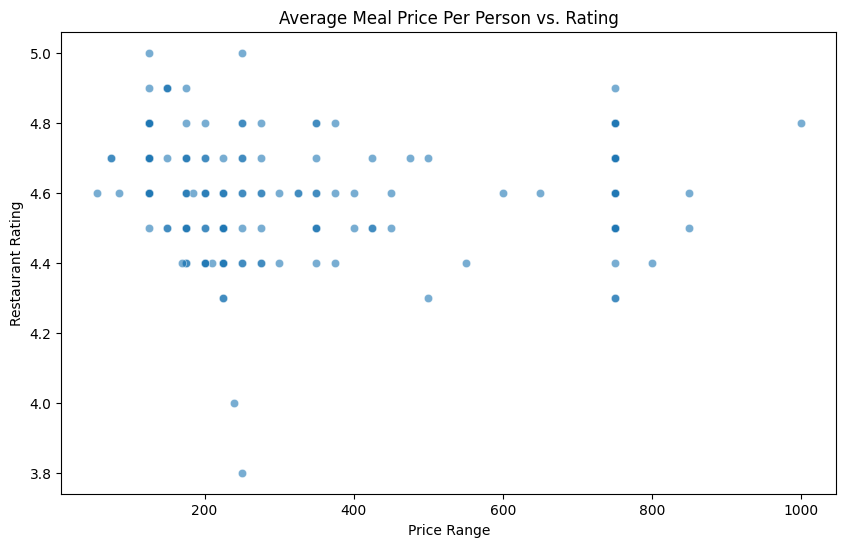

In [21]:
#Price vs. Rating
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Avg_Price'], y=df['Rating_Value'], alpha=0.6)
plt.xlabel("Price Range")
plt.ylabel("Restaurant Rating")
plt.title("Average Meal Price Per Person vs. Rating")
plt.show()

C:\Users\Game\AppData\Local\Temp\ipykernel_8792\3330382330.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_rated_suburbs.index, y=top_rated_suburbs.values, palette="coolwarm")


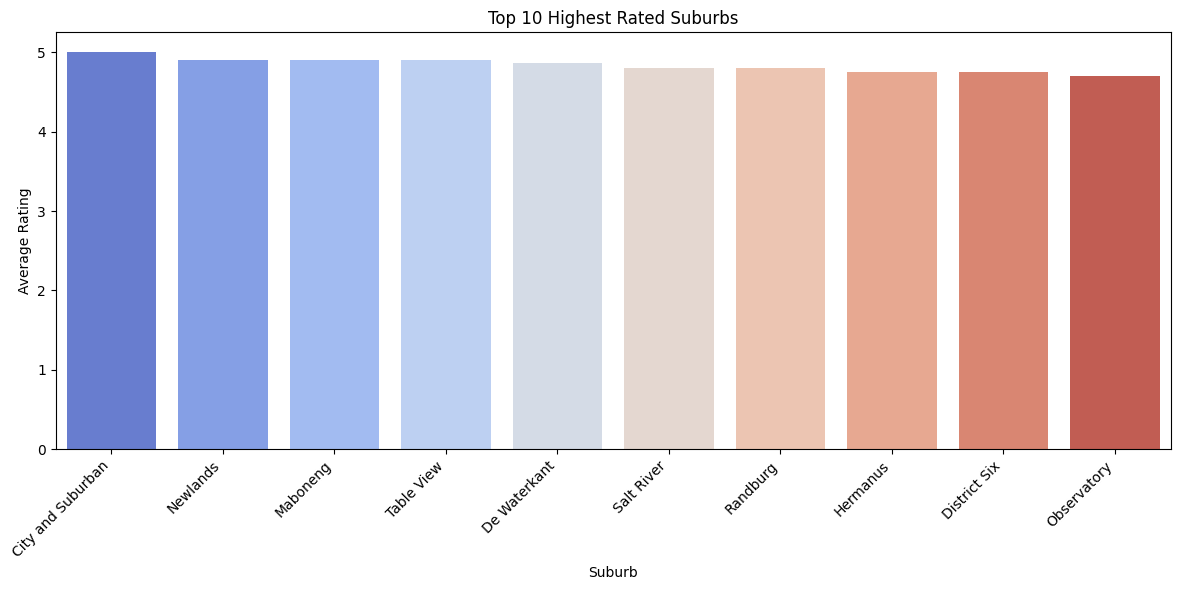

In [22]:
#Visualizing suburbs with the most top rated suburbs
suburb_columns = [col for col in df.columns if col.startswith('Suburb_')]

suburb_ratings = {}
for col in suburb_columns:
    suburb_name = col.replace('Suburb_', '')
    suburb_restaurants = df[df[col] == 1]
    if len(suburb_restaurants) > 0:  
        avg_rating = suburb_restaurants['Rating_Value'].mean()
        suburb_ratings[suburb_name] = avg_rating

suburb_rating_series = pd.Series(suburb_ratings)

top_rated_suburbs = suburb_rating_series.sort_values(ascending=False)[:10]

plt.figure(figsize=(12, 6))
sns.barplot(x=top_rated_suburbs.index, y=top_rated_suburbs.values, palette="coolwarm")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Suburb")
plt.ylabel("Average Rating")
plt.title("Top 10 Highest Rated Suburbs")
plt.tight_layout()  
plt.show()

C:\Users\Game\AppData\Local\Temp\ipykernel_8792\1233362678.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_suburbs.index, y=top_suburbs.values, palette="viridis")


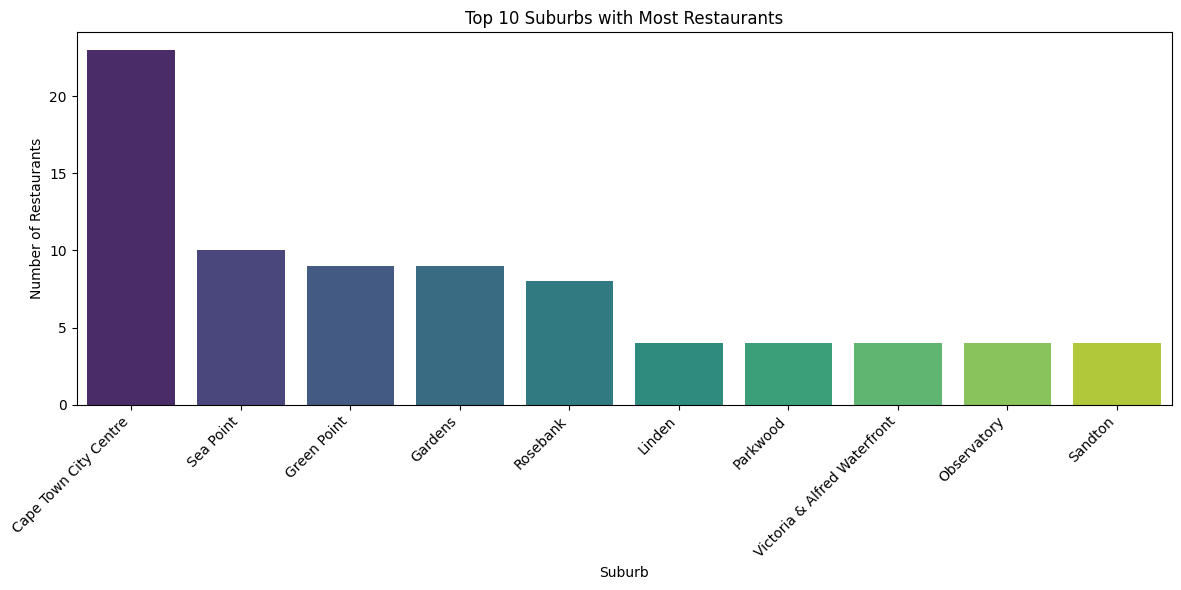

In [23]:
#Visualizing top 10 suburbs with the most amount restaurants
suburb_columns = [col for col in df.columns if col.startswith('Suburb_')]
suburb_counts = {}
for col in suburb_columns:
    suburb_name = col.replace('Suburb_', '')
    count = df[col].sum()
    suburb_counts[suburb_name] = count

suburb_series = pd.Series(suburb_counts)

top_suburbs = suburb_series.sort_values(ascending=False)[:10]

plt.figure(figsize=(12, 6))
sns.barplot(x=top_suburbs.index, y=top_suburbs.values, palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Suburb")
plt.ylabel("Number of Restaurants")
plt.title("Top 10 Suburbs with Most Restaurants")
plt.tight_layout()  
plt.show()

Percentage of high-rated restaurants: 82.21%


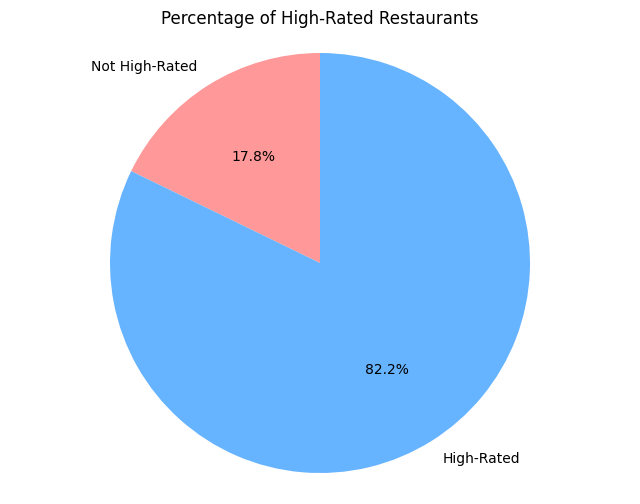

In [24]:
# Calculate the percentage of high-rated restaurants
high_rated_percentage = df['High_Rated'].mean() * 100
print(f"Percentage of high-rated restaurants: {high_rated_percentage:.2f}%")

# 1. Create a pie chart for high-rated vs. not high-rated
plt.figure(figsize=(8, 6))
labels = ['Not High-Rated', 'High-Rated']
sizes = [(100 - high_rated_percentage), high_rated_percentage]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.axis('equal')
plt.title('Percentage of High-Rated Restaurants')
plt.show()


Province
Gauteng         65.277778
Western Cape    95.604396
Name: High_Rated, dtype: float64


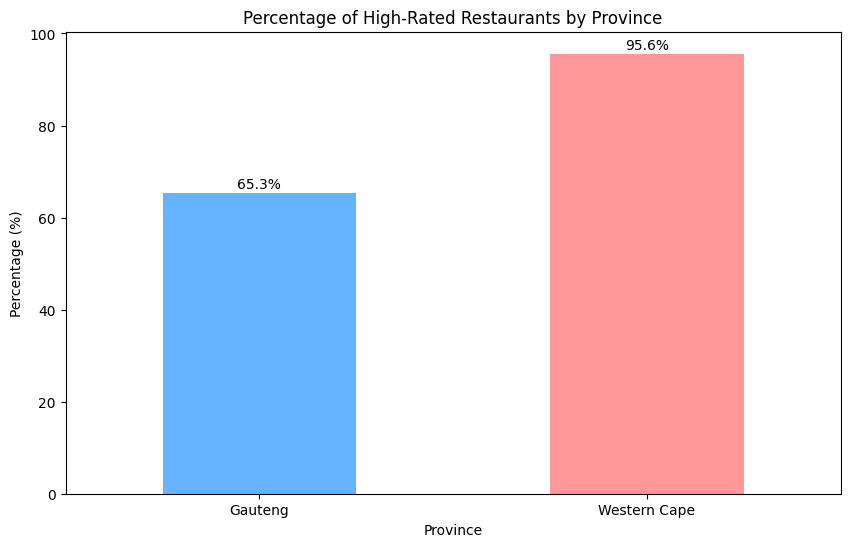

In [25]:
#Comparing high-rated restaurants by province
province_high_rated = df.groupby('Province')['High_Rated'].mean() * 100
print(province_high_rated)

# Bar chart comparing provinces
plt.figure(figsize=(10, 6))
province_high_rated.plot(kind='bar', color=['#66b3ff', '#ff9999'])
plt.title('Percentage of High-Rated Restaurants by Province')
plt.ylabel('Percentage (%)')
plt.xlabel('Province')
plt.xticks(rotation=0)
for i, v in enumerate(province_high_rated):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center')
plt.show()